# Gibbs Distribution from Second Law
https://arxiv.org/pdf/2008.13132.pdf

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import jax.numpy as np
from jax import grad
import jax
from tqdm import tqdm

/Users/shiro/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
sns.set_style("ticks")
sns.set_context("paper", 2, {"lines.linewidth": 2})

In [4]:
def calc_ising_model_exp_family_component(state, ex_field, coupling_const, inv_temp):
    # exp_family = np.dot(parameter, conj_var) + remaining
    parameter = np.array([inv_temp * ex_field, inv_temp * coupling_const])
    conj_var = np.array([np.sum(state), np.sum(np.array([state[i] * state[i + 1] for i in range(len(state) - 1)]))])
    remaining = 0
    return parameter, conj_var, remaining

def calc_hamiltonian(parameter, conj_var, remaining, inv_temp):
    hamiltonian = (- np.dot(parameter, conj_var) - remaining) / inv_temp
    return hamiltonian

def calc_massieu_func(parameter, conj_var, remaining):
    massieu_func = np.log(np.sum(np.exp(parameter * conj_var + remaining)))
    return massieu_func

def calc_free_energy(massieu_func, inv_temp):
    free_energy = - massieu_func / inv_temp
    return free_energy

def extract_work(work, init_hamiltonian, hamiltonian, init_free_energy, free_energy):
    work += init_hamiltonian - hamiltonian + free_energy - init_free_energy
    return work

def calc_work(state, ex_field, coupling_const, inv_temp, init_hamiltonian, hamiltonian):
    parameter, conj_var, remaining = calc_ising_model_exp_family_component(state, ex_field, coupling_const, inv_temp)
    hamiltonian = calc_hamiltonian(parameter, conj_var, remaining, inv_temp)
    massieu_func =  calc_massieu_func(parameter, conj_var, remaining)
    free_energy = calc_free_energy(massieu_func, inv_temp)
    work = init_hamiltonian - hamiltonian + free_energy - init_free_energy
    return work

def calc_exp_family_density(parameter, conj_var, remaining, massieu_func):
    density = np.exp(np.dot(parameter, conj_var) + remaining - massieu_func)
    return density

def calc_negative_log_likelihood(parameter, conj_var, remaining, massieu_func):
    nll = - (np.dot(parameter, conj_var) + remaining - massieu_func)
    return nll

def kl_div(parameter_1, parameter_2, conj_var_expectation_1, massieu_func_1, massieu_func_2):
    kl_div = (parameter_1 - parameter_2) * conj_var_expectation_1 - massieu_func_1 + massieu_func_2
    return kl_div

def update_param(loss_fn, parameter, argnums, learning_rate=0.1, num_iter=100):
    for _ in range(num_iter):
        grads = - grad(loss_fn, argnums=argnums)(item for item in parameter)
        parameter -= learning_rate * grads
    return parameter

In [12]:
inv_temp = 2.0
ex_field = 0.0
coupling_const = 0.5
state_dim = 2
seed = 0
key = jax.random.PRNGKey(seed)
state = jax.random.choice(key, a=np.array([-1.0, 1.0]), shape=[2])
num_cycle = 100
work = 0.0
iter_for_param_update = 100
learning_rate = 0.1

work_list = []
for step in tqdm(range(num_cycle)):
    parameter, conj_var, remaining = calc_ising_model_exp_family_component(state, ex_field, coupling_const, inv_temp)
    hamiltonian = calc_hamiltonian(parameter, conj_var, remaining, inv_temp)
    massieu_func = calc_massieu_func(parameter, conj_var, remaining)
    free_energy = calc_free_energy(massieu_func, inv_temp)
    if step == 0:
        init_hamiltonian = copy.deepcopy(hamiltonian)
        init_free_energy = copy.deepcopy(free_energy)
    work = extract_work(work, init_hamiltonian, hamiltonian, init_free_energy, free_energy)
    work_list.append(work)
    # Naximum liklihood maximization strategy
    for _ in range(iter_for_param_update):
        grads = - grad(calc_negative_log_likelihood, argnums=(0))(parameter, conj_var, remaining, massieu_func)
        parameter -= learning_rate * grads

    # Set status to minimize work
    for _ in range(iter_for_param_update):
        grads = - grad(calc_work, argnums=(0))(state, ex_field, coupling_const, inv_temp, init_hamiltonian, hamiltonian)
        state -= learning_rate * grads

    # parameter = update_param(calc_exp_family_density, parameter, argnums=(0, 1))
    # state = update_param(calc_work, (state, ex_field, coupling_const, inv_temp, init_hamiltonian, hamiltonian), argnums=(0))

100%|██████████| 1000/1000 [11:03<00:00,  1.51it/s]


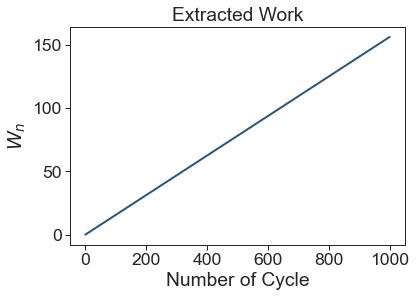

In [14]:
plt.plot(work_list, color=(0.188, 0.333, 0.454))
plt.title('Extracted Work')
plt.ylabel(r'$W_n$')
plt.xlabel('Number of Cycle')
plt.show()